## Find the normalized amplitude and use it as  a song detector

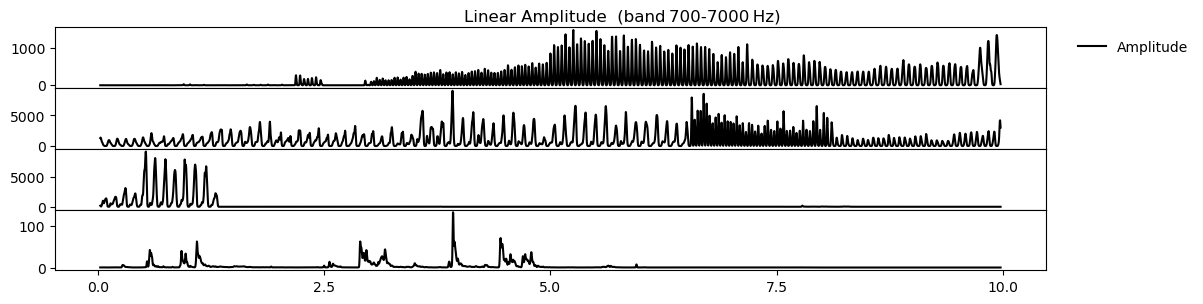

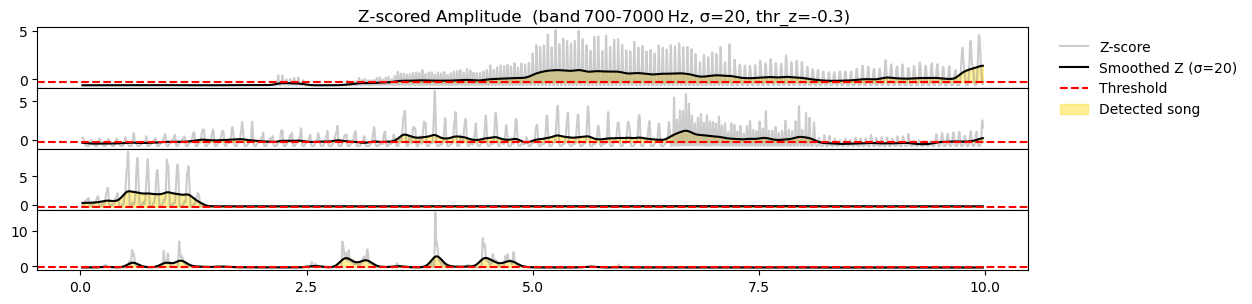

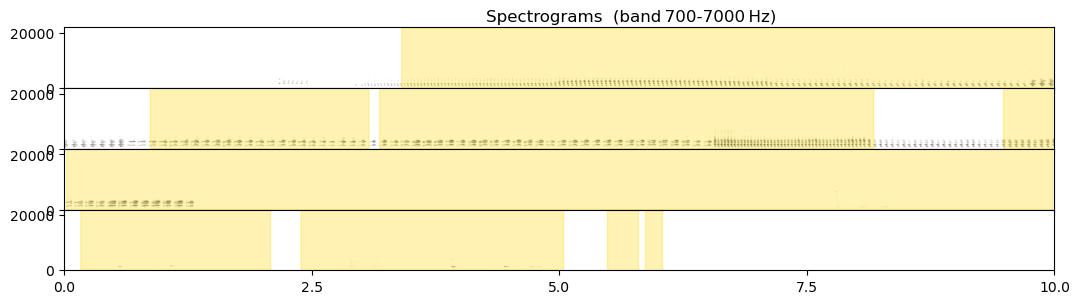


Detected song intervals (s):
      3.40 –     9.97
     10.87 –    13.08
     13.19 –    18.18
     19.48 –    19.97
     20.02 –    29.97
     30.17 –    32.09
     32.39 –    35.05
     35.48 –    35.80
     35.87 –    36.04


In [15]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import List, Tuple, Optional

# ------------------------------------------------------------
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, height_inches = get_screen_resolution()

# ------------------------------------------------------------
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold_z: Optional[float] = None
    ) -> List[Tuple[float, float]]:

    eps = np.finfo(float).eps

    # ─── Load & band‑pass filter ───────────────────────────────────────
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ─── Segment bookkeeping ──────────────────────────────────────────
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ─── Prepare figures (no vertical spacing) ───────────────────────
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig2, axs_z   = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig3, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    if n_seg == 1:
        axs_lin, axs_z, axs_spc = [axs_lin], [axs_z], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ─── Per‑segment processing ───────────────────────────────────────
    for i in range(n_seg):
        # extract segment (zero‑pad at end if needed)
        seg = np.zeros(seg_len)
        start_idx = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start_idx))] = data[start_idx:start_idx + seg_len]

        # spectrogram for visualization
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048/8),
                                nperseg=2048, noverlap=2048-119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # compute band‑limited linear amplitude
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)

        # ─── Z‑score normalization & thresholding ─────────────────────
        z   = (amp - amp.mean()) / amp.std()
        z_s = gaussian_filter1d(z, sigma=sigma)
        if threshold_z is None and i == 0:
            threshold_z = np.percentile(z_s, 90)
        mask_z = z_s > threshold_z

        # collect absolute intervals
        detected.extend(mask_to_intervals(mask_z, t, i * segment_duration))

        # ─── Linear amplitude plot (RAW only) ─────────────────────────
        axL = axs_lin[i]
        axL.plot(t, amp, color='black',
                 label='Amplitude' if i == 0 else None)
        axL.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ─── Z‑score amplitude plot ─────────────────────────────────
        axZ = axs_z[i]
        axZ.plot(t, z,   color='gray', alpha=0.4,
                 label='Z‑score' if i == 0 else None)
        axZ.plot(t, z_s, color='black',
                 label=f'Smoothed Z (σ={sigma})' if i == 0 else None)
        axZ.axhline(threshold_z, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axZ.fill_between(t, z_s, threshold_z, where=mask_z,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axZ.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axZ.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ─── Spectrogram plot ───────────────────────────────────────
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_z,
                         color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg-1 else np.linspace(0, segment_duration, 5))

    # ─── Titles & layout ─────────────────────────────────────────
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp})', fontsize=12)
    fig2.suptitle(f'Z‑scored Amplitude  (band {bp}, σ={sigma}, thr_z={threshold_z:.1f})',
                  fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)
    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)

    plt.show()

    # ─── Print detected intervals ──────────────────────────────────
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")

    return detected

# ------------------------------------------------------------
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=20,
            threshold_z=-0.3
        )
    else:
        print("Example WAV not found:", wav_path)
